## TextSlider + SDXL

In [ ]:
import torch
from pipeline_stable_diffusion_xl import StableDiffusionXLPipeline
import matplotlib.pyplot as plt

/scratch3/users/nickchiu/.miniconda/envs/textslider/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda:0"
ckpt_name = 'stabilityai/stable-diffusion-xl-base-1.0'
pipe = StableDiffusionXLPipeline.from_pretrained(ckpt_name, torch_dtype=torch.bfloat16)
_ = pipe.to(device)

Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  3.56it/s]


### Determine the attribute, input prompt, slider scales

In [3]:
attribute = "smile"

# load the clip lora
lora_clip_path = f"models/{attribute}slider_rank4/clip_lora"
state_dict = pipe.lora_state_dict(lora_clip_path)[0]
pipe.load_lora_into_text_encoder(state_dict, network_alphas=None, text_encoder=pipe.text_encoder, prefix="text_encoder", adapter_name="slider_clip")

# load the openclip lora
lora_openclip_path = f"models/{attribute}slider_rank4/openclip_lora"
state_dict = pipe.lora_state_dict(lora_openclip_path)[0]
pipe.load_lora_into_text_encoder(state_dict, network_alphas=None, text_encoder=pipe.text_encoder_2, prefix="text_encoder", adapter_name="slider_openclip")

In [7]:
prompt = "image of a person, photorealistic"

# slider scale (typically 0 ~ 0.3 have better results)
scales = torch.linspace(0, 0.3, 5)

seed = 1006
start_noise = 800

In [8]:
images_list = []
for s in scales:
    im = pipe(
            prompt=prompt,
            generator=torch.manual_seed(seed),
            guidance_scale=7.5,
            start_noise=start_noise,
            scale=s,
        ).images[0]
    images_list.append(im)

100%|██████████| 50/50 [00:11<00:00,  4.24it/s]


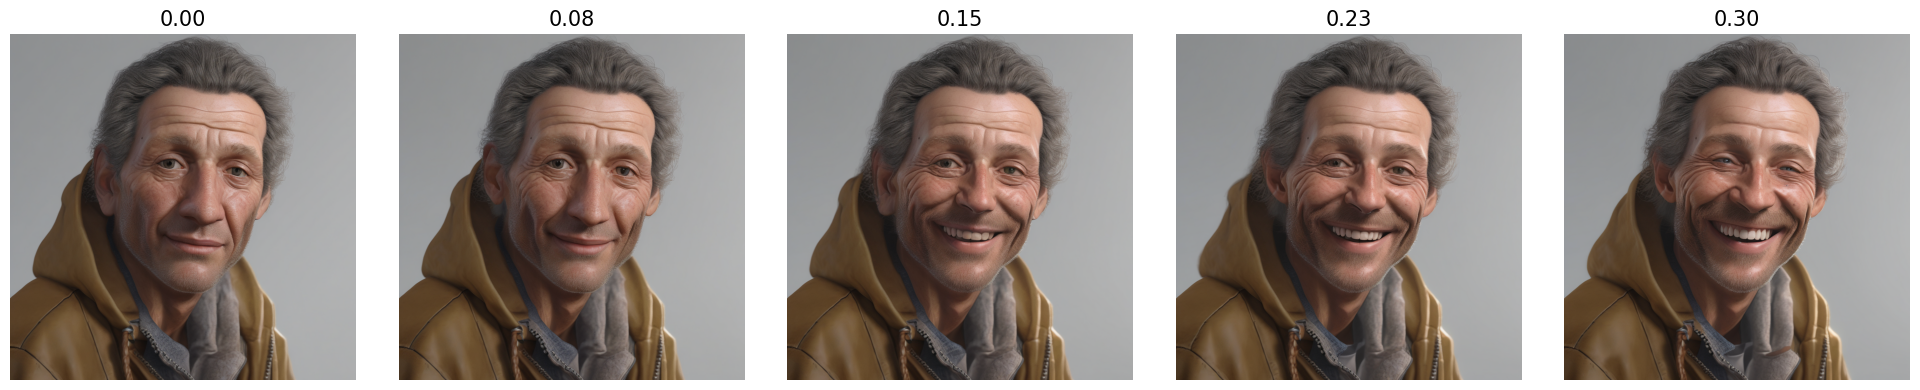

In [9]:
fig, ax = plt.subplots(1, len(images_list), figsize=(20,4))
for i, a in enumerate(ax):
    a.imshow(images_list[i])
    a.set_title(f"{scales[i]:.2f}",fontsize=15)
    a.axis('off')
    plt.tight_layout()
plt.show()